In [35]:
import pandas as pd
import numpy as np
import keras

from utils import *

In [7]:
df = get_bpi('2015-01-01', '2020-05-14')

In [9]:
df.tail()

2020-05-10    8465.4500
2020-05-11    8857.0625
2020-05-12    8729.9500
2020-05-13    9099.2000
2020-05-14    9582.5825
Name: bpi, dtype: float64

In [11]:
def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  #   wave 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # + wave 2
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)   # + noise
    return series[..., np.newaxis].astype(np.float32)

series = generate_time_series(10, 51)

In [12]:
series.shape

(10, 51, 1)

---
### Below notebook is based on the tutorial https://www.thepythoncode.com/article/stock-price-prediction-in-python-using-tensorflow-2-and-keras

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from keras.callbacks import EarlyStopping
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from yahoo_fin import stock_info as si
from collections import deque

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import os
import random



Using TensorFlow backend.


In [3]:
# set seed, so we can get the same results after rerunning several times
np.random.seed(314)
tf.random.set_seed(314)
random.seed(314)

In [22]:
## Hyper-parameters
import os
import time
from tensorflow.keras.layers import LSTM


# Window size or the sequence length
N_STEPS = 70
# Lookup step, 1 is the next day
LOOKUP_STEP = 10

# test ratio size, 0.2 is 20%
TEST_SIZE = 0.2
# features to use
# FEATURE_COLUMNS = ["adjclose", "volume", "open", "high", "low"]
FEATURE_COLUMNS = ["adjclose"]
# date now
date_now = time.strftime("%Y-%m-%d")

### model parameters

N_LAYERS = 3
# LSTM cell
CELL = LSTM
# 256 LSTM neurons
UNITS = 256
# 40% dropout
DROPOUT = 0.4
# whether to use bidirectional RNNs
BIDIRECTIONAL = False

### training parameters

# mean absolute error loss
# LOSS = "mae"
# huber loss
LOSS = "huber_loss"
OPTIMIZER = "adam"
BATCH_SIZE = 64
EPOCHS = 100

# Apple stock market
ticker = "AAPL"
ticker_data_filename = os.path.join("data", f"{ticker}_{date_now}.csv")
# model name to save, making it as unique as possible based on parameters
model_name = f"{date_now}_{ticker}-{LOSS}-{OPTIMIZER}-{CELL.__name__}-seq-{N_STEPS}-step-{LOOKUP_STEP}-layers-{N_LAYERS}-units-{UNITS}"
if BIDIRECTIONAL:
    model_name += "-b"

In [5]:
def load_data(ticker, n_steps=50, scale=True, shuffle=True, lookup_step=1, 
                test_size=0.2, feature_columns=['adjclose', 'volume', 'open', 'high', 'low']):
    """
    Loads data from Yahoo Finance source, as well as scaling, shuffling, normalizing and splitting.
    Params:
        ticker (str/pd.DataFrame): the ticker you want to load, examples include AAPL, TESL, etc.
        n_steps (int): the historical sequence length (i.e window size) used to predict, default is 50
        scale (bool): whether to scale prices from 0 to 1, default is True
        shuffle (bool): whether to shuffle the data, default is True
        lookup_step (int): the future lookup step to predict, default is 1 (e.g next day)
        test_size (float): ratio for test data, default is 0.2 (20% testing data)
        feature_columns (list): the list of features to use to feed into the model, default is everything grabbed from yahoo_fin
    """
    # see if ticker is already a loaded stock from yahoo finance
    if isinstance(ticker, str):
        # load it from yahoo_fin library
        df = si.get_data(ticker)
    elif isinstance(ticker, pd.DataFrame):
        # already loaded, use it directly
        df = ticker
    else:
        raise TypeError("ticker can be either a str or a `pd.DataFrame` instances")

    # this will contain all the elements we want to return from this function
    result = {}
    # we will also return the original dataframe itself
    result['df'] = df.copy()

    # make sure that the passed feature_columns exist in the dataframe
    for col in feature_columns:
        assert col in df.columns, f"'{col}' does not exist in the dataframe."

    if scale:
        column_scaler = {}
        # scale the data (prices) from 0 to 1
        for column in feature_columns:
            scaler = preprocessing.MinMaxScaler()
            df[column] = scaler.fit_transform(np.expand_dims(df[column].values, axis=1))
            column_scaler[column] = scaler

        # add the MinMaxScaler instances to the result returned
        result["column_scaler"] = column_scaler

    # add the target column (label) by shifting by `lookup_step`
    df['future'] = df['adjclose'].shift(-lookup_step)
#     print(df.tail(10))

    # last `lookup_step` columns contains NaN in future column
    # get them before droping NaNs
    last_sequence = np.array(df[feature_columns].tail(lookup_step))
#     print("LAST SEQUENCE:\n", last_sequence)
    
    # drop NaNs
    df.dropna(inplace=True)
#     print(df.tail(10))

    sequence_data = []
    sequences = deque(maxlen=n_steps)

    for entry, target in zip(df[feature_columns].values, df['future'].values):
        sequences.append(entry)
        if len(sequences) == n_steps:
            sequence_data.append([np.array(sequences), target])

    # get the last sequence by appending the last `n_step` sequence with `lookup_step` sequence
    # for instance, if n_steps=50 and lookup_step=10, last_sequence should be of 59 (that is 50+10-1) length
    # this last_sequence will be used to predict in future dates that are not available in the dataset
    last_sequence = list(sequences) + list(last_sequence)
    # shift the last sequence by -1
    last_sequence = np.array(pd.DataFrame(last_sequence).shift(-1).dropna())
    # add to result
    result['last_sequence'] = last_sequence
    
    # construct the X's and y's
    X, y = [], []
    for seq, target in sequence_data:
        X.append(seq)
        y.append(target)

    # convert to numpy arrays
    X = np.array(X)
    y = np.array(y)

    # reshape X to fit the neural network
    X = X.reshape((X.shape[0], X.shape[2], X.shape[1]))
    
    # split the dataset
    result["X_train"], result["X_test"], result["y_train"], result["y_test"] = train_test_split(X, y, 
                                                                                test_size=test_size, shuffle=shuffle)
    # return the result
    return result

In [27]:
def create_model(sequence_length, units=256, cell=LSTM, n_layers=2, dropout=0.3,
                 loss="mean_absolute_error", optimizer="rmsprop", bidirectional=False,
                 last_layer_neurons=1):
    model = Sequential()
    
    for i in range(n_layers):
        if i == 0:
            # first layer
            if bidirectional:
                model.add(Bidirectional(cell(units, return_sequences=True), input_shape=(None, sequence_length)))
            else:
                model.add(cell(units, return_sequences=True, input_shape=(None, sequence_length)))
                
        elif i == n_layers - 1:
            # last layer
            if bidirectional:
                model.add(Bidirectional(cell(units, return_sequences=False)))
            else:
                model.add(cell(units, return_sequences=False))
                
        else:
            # hidden layers
            if bidirectional:
                model.add(Bidirectional(cell(units, return_sequences=True)))
            else:
                model.add(cell(units, return_sequences=True))
        # add dropout after each layer
        model.add(Dropout(dropout))
        
    model.add(Dense(last_layer_neurons, activation="linear"))
    model.compile(loss=loss, metrics=["mean_absolute_error"], optimizer=optimizer)
    return model

In [7]:
data = load_data(ticker, N_STEPS, lookup_step=LOOKUP_STEP, test_size=TEST_SIZE, feature_columns=FEATURE_COLUMNS)

In [8]:
data['df'].tail(3)

,open,high,low,close,adjclose,volume,ticker
2020-05-18,313.170013,316.500000,310.320007,314.959991,314.959991,33843100.0,AAPL
2020-05-19,315.029999,318.519989,313.010010,313.140015,313.140015,25432400.0,AAPL
2020-05-20,316.679993,319.519989,316.519989,319.230011,319.230011,27848000.0,AAPL


In [9]:
data.keys()

dict_keys(['df', 'column_scaler', 'last_sequence', 'X_train', 'X_test', 'y_train', 'y_test'])

In [10]:
data['last_sequence'][:5]

array([[0.97679202],
       [1.        ],
       [0.99287552],
       [0.9931202 ],
       [0.97492688]])

In [11]:
data['X_train'][0][0].shape

(70,)

In [14]:
# create these folders if they does not exist
if not os.path.isdir("results"):
    os.mkdir("results")

if not os.path.isdir("logs"):
    os.mkdir("logs")

if not os.path.isdir("data"):
    os.mkdir("data")

# load the data
data = load_data(ticker, N_STEPS, lookup_step=LOOKUP_STEP, test_size=TEST_SIZE, feature_columns=FEATURE_COLUMNS)

# save the dataframe
data["df"].to_csv(ticker_data_filename)

# construct the model
model = create_model(N_STEPS, loss=LOSS, units=UNITS, cell=CELL, n_layers=N_LAYERS,
                     dropout=DROPOUT, optimizer=OPTIMIZER, bidirectional=BIDIRECTIONAL)

# some tensorflow callbacks
# checkpointer = ModelCheckpoint(os.path.join("results", model_name + ".h5"), save_weights_only=True, save_best_only=True, verbose=1)
tensorboard = TensorBoard(log_dir=os.path.join("logs", model_name))
early_stopping = EarlyStopping(patience=5, monitor="val_loss", restore_best_weights=True)

print(model.summary())

history = model.fit(data["X_train"], data["y_train"],
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=(data["X_test"], data["y_test"]),
                    callbacks=[tensorboard, early_stopping],
                    verbose=1)

model.save(os.path.join("results", model_name) + ".h5")

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, None, 256)         334848    
_________________________________________________________________
dropout_2 (Dropout)          (None, None, 256)         0         
_________________________________________________________________
lstm_4 (LSTM)                (None, None, 256)         525312    
_________________________________________________________________
dropout_3 (Dropout)          (None, None, 256)         0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 256)               525312    
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                

In [15]:
def plot_graph(model, data):
    y_test = data["y_test"]
    X_test = data["X_test"]
    y_pred = model.predict(X_test)
    y_test = np.squeeze(data["column_scaler"]["adjclose"].inverse_transform(np.expand_dims(y_test, axis=0)))
    y_pred = np.squeeze(data["column_scaler"]["adjclose"].inverse_transform(y_pred))
    plt.plot(y_test[-200:], c='b')
    plt.plot(y_pred[-200:], c='r')
    plt.xlabel("Days")
    plt.ylabel("Price")
    plt.legend(["Actual Price", "Predicted Price"])
    plt.show()


def get_accuracy(model, data):
    y_test = data["y_test"]
    X_test = data["X_test"]
    y_pred = model.predict(X_test)
    y_test = np.squeeze(data["column_scaler"]["adjclose"].inverse_transform(np.expand_dims(y_test, axis=0)))
    y_pred = np.squeeze(data["column_scaler"]["adjclose"].inverse_transform(y_pred))
    y_pred = list(map(lambda current, future: int(float(future) > float(current)), y_test[:-LOOKUP_STEP], y_pred[LOOKUP_STEP:]))
    y_test = list(map(lambda current, future: int(float(future) > float(current)), y_test[:-LOOKUP_STEP], y_test[LOOKUP_STEP:]))
    return accuracy_score(y_test, y_pred)


def predict(model, data, classification=False):
    # retrieve the last sequence from data
    last_sequence = data["last_sequence"][:N_STEPS]
    # retrieve the column scalers
    column_scaler = data["column_scaler"]
    # reshape the last sequence
    last_sequence = last_sequence.reshape((last_sequence.shape[1], last_sequence.shape[0]))
    # expand dimension
    last_sequence = np.expand_dims(last_sequence, axis=0)
    # get the prediction (scaled from 0 to 1)
    prediction = model.predict(last_sequence)
    # get the price (by inverting the scaling)
    predicted_price = column_scaler["adjclose"].inverse_transform(prediction)[0][0]
    return predicted_price

In [70]:
# # load the optimal model weights
# model_path = os.path.join("results", model_name) + ".h5"
# model.load_weights(model_path)

In [16]:
# load the data with shuffle = False
data = load_data(ticker, N_STEPS, lookup_step=LOOKUP_STEP, test_size=TEST_SIZE,
                 feature_columns=FEATURE_COLUMNS, shuffle=False)

Mean Absolute Error: 4.6384645
Future price after 1 days is 290.95$
Accuracy Score: 0.48429584599797365


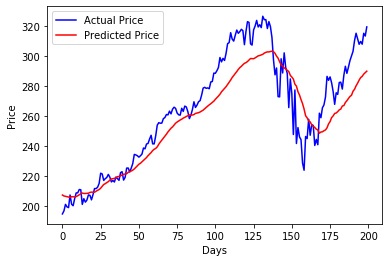

In [17]:
# evaluate the model
mse, mae = model.evaluate(data["X_test"], data["y_test"], verbose=0)
# calculate the mean absolute error (inverse scaling)
mean_absolute_error = data["column_scaler"]["adjclose"].inverse_transform(mae.reshape(1, -1))[0][0]
print("Mean Absolute Error:", mean_absolute_error)
# predict the future price
future_price = predict(model, data)
print(f"Future price after {LOOKUP_STEP} days is {future_price:.2f}$")
print("Accuracy Score:", get_accuracy(model, data))
plot_graph(model, data)

In [28]:
# create these folders if they does not exist
if not os.path.isdir("results"):
    os.mkdir("results")

if not os.path.isdir("logs"):
    os.mkdir("logs")

if not os.path.isdir("data"):
    os.mkdir("data")

# load the data
data = load_data(ticker, N_STEPS, lookup_step=LOOKUP_STEP, test_size=TEST_SIZE, feature_columns=FEATURE_COLUMNS)

# save the dataframe
data["df"].to_csv(ticker_data_filename)

# construct the model
model = create_model(N_STEPS, loss=LOSS, units=UNITS, cell=CELL, n_layers=N_LAYERS,
                     dropout=DROPOUT, optimizer=OPTIMIZER, bidirectional=BIDIRECTIONAL, last_layer_neurons=10)

# some tensorflow callbacks
# checkpointer = ModelCheckpoint(os.path.join("results", model_name + ".h5"), save_weights_only=True, save_best_only=True, verbose=1)
tensorboard = TensorBoard(log_dir=os.path.join("logs", model_name))
early_stopping = EarlyStopping(patience=5, monitor="val_loss", restore_best_weights=True)

print(model.summary())

history = model.fit(data["X_train"], data["y_train"],
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=(data["X_test"], data["y_test"]),
                    callbacks=[tensorboard, early_stopping],
                    verbose=1)

model.save(os.path.join("results", model_name) + ".h5")

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, None, 256)         334848    
_________________________________________________________________
dropout_11 (Dropout)         (None, None, 256)         0         
_________________________________________________________________
lstm_13 (LSTM)               (None, None, 256)         525312    
_________________________________________________________________
dropout_12 (Dropout)         (None, None, 256)         0         
_________________________________________________________________
lstm_14 (LSTM)               (None, 256)               525312    
_________________________________________________________________
dropout_13 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)               

In [29]:
# load the data with shuffle = False
data = load_data(ticker, N_STEPS, lookup_step=LOOKUP_STEP, test_size=TEST_SIZE,
                 feature_columns=FEATURE_COLUMNS, shuffle=False)

Mean Absolute Error: 7.952697
Future price after 10 days is 280.53$


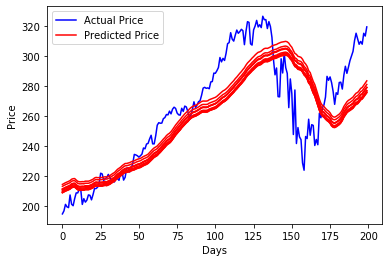

In [31]:
# evaluate the model
mse, mae = model.evaluate(data["X_test"], data["y_test"], verbose=0)
# calculate the mean absolute error (inverse scaling)
mean_absolute_error = data["column_scaler"]["adjclose"].inverse_transform(mae.reshape(1, -1))[0][0]
print("Mean Absolute Error:", mean_absolute_error)
# predict the future price
future_price = predict(model, data)
print(f"Future price after {LOOKUP_STEP} days is {future_price:.2f}$")
# print("Accuracy Score:", get_accuracy(model, data))
plot_graph(model, data)

---
# Predykcja kolejnych kroków w pętli

In [119]:
# evaluate the model
mse, mae = model.evaluate(data["X_test"], data["y_test"], verbose=0)
# calculate the mean absolute error (inverse scaling)
mean_absolute_error = data["column_scaler"]["adjclose"].inverse_transform(mae.reshape(1, -1))[0][0]
print("Mean Absolute Error:", mean_absolute_error)

# predict the future price
last_sequence_raw = data["last_sequence"][:N_STEPS]

price_predictions = []
for i in range(10): 
#     print(i, last_sequence_raw)
    # retrieve the column scalers
    column_scaler = data["column_scaler"]
    # reshape the last sequence
    last_sequence = last_sequence_raw[i:]
    last_sequence = last_sequence.reshape((last_sequence.shape[1], last_sequence.shape[0]))
    # expand dimension
    last_sequence = np.expand_dims(last_sequence, axis=0)
    # get the prediction (scaled from 0 to 1)
    prediction = model.predict(last_sequence)
    
    print(prediction)
    
    # get the price (by inverting the scaling)
    predicted_price = column_scaler["adjclose"].inverse_transform(prediction)[0][0]
    price_predictions.append(predicted_price)
    
    last_sequence_raw = np.concatenate([last_sequence_raw, prediction], axis=0)
    
print(price_predictions)

Mean Absolute Error: 3.5745761
[[0.93046445]]
[[0.92907035]]
[[0.9283682]]
[[0.92500484]]
[[0.9233128]]
[[0.92096955]]
[[0.9188676]]
[[0.9170002]]
[[0.913772]]
[[0.9116068]]
[303.63687, 303.18216, 302.95316, 301.85614, 301.30426, 300.53998, 299.8544, 299.24533, 298.1924, 297.4862]


In [ ]:
y_test = data["y_test"]
X_test = data["X_test"]
y_pred = model.predict(X_test)
y_test = np.squeeze(data["column_scaler"]["adjclose"].inverse_transform(np.expand_dims(y_test, axis=0)))
y_pred = np.squeeze(data["column_scaler"]["adjclose"].inverse_transform(y_pred))
plt.plot(y_test[-200:], c='b')
plt.plot(y_pred[-200:], c='r')
plt.xlabel("Days")
plt.ylabel("Price")
plt.legend(["Actual Price", "Predicted Price"])
plt.show()

Mean Absolute Error: 3.5988295
Future price after 20 days is 266.33$
Accuracy Score: 0.8208032955715757


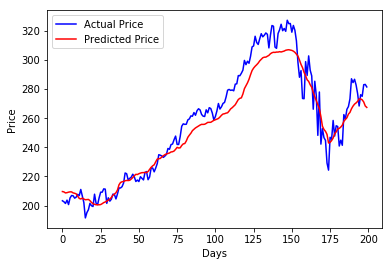

In [10]:
# evaluate the model
mse, mae = model.evaluate(data["X_test"], data["y_test"], verbose=0)
# calculate the mean absolute error (inverse scaling)
mean_absolute_error = data["column_scaler"]["adjclose"].inverse_transform(mae.reshape(1, -1))[0][0]
print("Mean Absolute Error:", mean_absolute_error)
# predict the future price
future_price = predict(model, data)
print(f"Future price after {LOOKUP_STEP} days is {future_price:.2f}$")
print("Accuracy Score:", get_accuracy(model, data))
plot_graph(model, data)

---
# Predykcja kolejnych jednoczesnie (TimeDistributed)

In [33]:
def create_simple_model(sequence_length, units=256, cell=LSTM, n_layers=2, dropout=0.3,
                 loss="mean_absolute_error", optimizer="rmsprop", bidirectional=False,
                 last_layer_neurons=1):
    
    model = keras.models.Sequential([
        keras.layers.SimpleRNN(units, return_sequences=True, input_shape=[None, sequence_length]),
        keras.layers.SimpleRNN(units, return_sequences=True),
        keras.layers.TimeDistributed(keras.layers.Dense(10))
    ])
        
    model.compile(loss=loss, metrics=["mean_absolute_error"], optimizer=optimizer)
    return model

In [36]:
# load the data
data = load_data(ticker, N_STEPS, lookup_step=LOOKUP_STEP, test_size=TEST_SIZE, feature_columns=FEATURE_COLUMNS)

# save the dataframe
data["df"].to_csv(ticker_data_filename)

# construct the model
model = create_simple_model(N_STEPS, loss=LOSS, units=UNITS, cell=CELL, n_layers=N_LAYERS,
                     dropout=DROPOUT, optimizer=OPTIMIZER, bidirectional=BIDIRECTIONAL)

# some tensorflow callbacks
# checkpointer = ModelCheckpoint(os.path.join("results", model_name + ".h5"), save_weights_only=True, save_best_only=True, verbose=1)
tensorboard = TensorBoard(log_dir=os.path.join("logs", model_name))
early_stopping = EarlyStopping(patience=5, monitor="val_loss", restore_best_weights=True)

print(model.summary())

history = model.fit(data["X_train"], data["y_train"],
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=(data["X_test"], data["y_test"]),
                    callbacks=[tensorboard, early_stopping],
                    verbose=1)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, None, 256)         83712     
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, None, 256)         131328    
_________________________________________________________________
time_distributed_1 (TimeDist (None, None, 10)          2570      
Total params: 217,610
Trainable params: 217,610
Non-trainable params: 0
_________________________________________________________________
None


ValueError: Error when checking target: expected time_distributed_1 to have 3 dimensions, but got array with shape (7890, 1)

In [119]:
# evaluate the model
mse, mae = model.evaluate(data["X_test"], data["y_test"], verbose=0)
# calculate the mean absolute error (inverse scaling)
mean_absolute_error = data["column_scaler"]["adjclose"].inverse_transform(mae.reshape(1, -1))[0][0]
print("Mean Absolute Error:", mean_absolute_error)

# predict the future price
last_sequence_raw = data["last_sequence"][:N_STEPS]

price_predictions = []
for i in range(10): 
#     print(i, last_sequence_raw)
    # retrieve the column scalers
    column_scaler = data["column_scaler"]
    # reshape the last sequence
    last_sequence = last_sequence_raw[i:]
    last_sequence = last_sequence.reshape((last_sequence.shape[1], last_sequence.shape[0]))
    # expand dimension
    last_sequence = np.expand_dims(last_sequence, axis=0)
    # get the prediction (scaled from 0 to 1)
    prediction = model.predict(last_sequence)
    
    print(prediction)
    
    # get the price (by inverting the scaling)
    predicted_price = column_scaler["adjclose"].inverse_transform(prediction)[0][0]
    price_predictions.append(predicted_price)
    
    last_sequence_raw = np.concatenate([last_sequence_raw, prediction], axis=0)
    
print(price_predictions)

Mean Absolute Error: 3.5745761
[[0.93046445]]
[[0.92907035]]
[[0.9283682]]
[[0.92500484]]
[[0.9233128]]
[[0.92096955]]
[[0.9188676]]
[[0.9170002]]
[[0.913772]]
[[0.9116068]]
[303.63687, 303.18216, 302.95316, 301.85614, 301.30426, 300.53998, 299.8544, 299.24533, 298.1924, 297.4862]


In [ ]:
y_test = data["y_test"]
X_test = data["X_test"]
y_pred = model.predict(X_test)
y_test = np.squeeze(data["column_scaler"]["adjclose"].inverse_transform(np.expand_dims(y_test, axis=0)))
y_pred = np.squeeze(data["column_scaler"]["adjclose"].inverse_transform(y_pred))
plt.plot(y_test[-200:], c='b')
plt.plot(y_pred[-200:], c='r')
plt.xlabel("Days")
plt.ylabel("Price")
plt.legend(["Actual Price", "Predicted Price"])
plt.show()

Mean Absolute Error: 3.5988295
Future price after 20 days is 266.33$
Accuracy Score: 0.8208032955715757


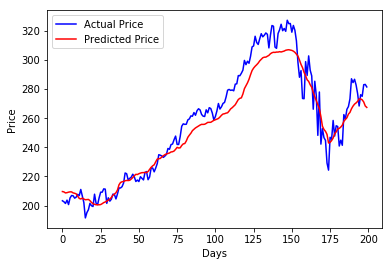

In [10]:
# evaluate the model
mse, mae = model.evaluate(data["X_test"], data["y_test"], verbose=0)
# calculate the mean absolute error (inverse scaling)
mean_absolute_error = data["column_scaler"]["adjclose"].inverse_transform(mae.reshape(1, -1))[0][0]
print("Mean Absolute Error:", mean_absolute_error)
# predict the future price
future_price = predict(model, data)
print(f"Future price after {LOOKUP_STEP} days is {future_price:.2f}$")
print("Accuracy Score:", get_accuracy(model, data))
plot_graph(model, data)